In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn import random_projection
import os
from pathlib import Path

#model related
import torch
import torchvision.models as models
from PIL import Image
import seaborn as sns

#statistical test and ploting: 
import time
import pickle

from itertools import combinations
from torch.nn import CosineSimilarity

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from help_functions import run_sim_on_all_possible_pairs , create_image_matches_dataframe , process_and_extract_activations_from_folder, compare_image_similarity_pickled_features

In [49]:

# number of matches for top x 
n_match=10

# target image number to compair to for top x 
target_image = 10

# either download or use a pre-downloaded pre-trained model
to_download = False

# to extact activations ?
to_extract = False # currently ignored

vgg16 = models.vgg16(pretrained=True,dropout=0)

# subset per layer 
subset_size=20

num_random_iterations = 1 #how many times to try and built an "optimal" rdm, as this number is larger more interations are tested. 

create_similarity_df=False #should we create or load the similarity df: 

selected_nodes=['features.4','features.9','features.16','features.23','features.30','classifier.1','classifier.4']
selected_dictionary={node:'level_'+str(i) for i,node in enumerate(selected_nodes)}


path = Path(r'C:\Users\User\Desktop\human similarity database\all images\DF20_300_manualy_selected')    
PATHS = list(path.iterdir())

In [5]:

def extract_similarity_contrast_by_layers(similarity_df:pd.DataFrame,layers:list,normalize=True,diagonal_value=100,create_contrast=True):
     #diagonal_value - this defines the value of the diagonal (when the layer is normalized the similarity of an image with itself is an arbitary number)
    if not normalize: 
        diagonal_value=1 #when not normalied, the value of the diagonal is the maximal similarity (1 when using cosine distance) 
    num_layers=len(layers)

    #create a dictionary to map from images names to numbers (so we can work with matrices indexes)
    all_image1=similarity_df['image1'].unique()
    all_image2=similarity_df['image2'].unique()
    all_images=set(np.hstack([all_image1,all_image2]))
    mapping_dict={key:i for i,key in enumerate(all_images)}
    #apply mapping to the similarity_dataframe
    similarity_df['image1_numeric']=similarity_df['image1'].apply(lambda x: mapping_dict[x])
    similarity_df['image2_numeric']=similarity_df['image2'].apply(lambda x: mapping_dict[x])

    #initialize empty matrices
    all_layers_matrices=np.zeros([len(all_images),len(all_images),num_layers])
    contrast_per_layer=np.zeros([num_layers,num_layers])

    #for each desired layer, create an n by n matrix
    for l,layer in enumerate(layers):
        #create a n by n matrix that contains the similairty between each possible image pair: 
        layer_matrix=np.zeros([len(all_images),len(all_images)])*np.nan
        for i,indexes in enumerate(similarity_df[['image1_numeric','image2_numeric']].values):
            if indexes[0]==indexes[1]:
                continue
            else: 
                layer_matrix[indexes[0],indexes[1]]=similarity_df.iloc[i][layer]
                layer_matrix[indexes[1],indexes[0]]=similarity_df.iloc[i][layer]
        
        if normalize: #make sure to not include the diagonal values (which are all maximumally similar) 
            layer_matrix=(layer_matrix-np.nanmean(layer_matrix))/np.nanstd(layer_matrix)
            np.fill_diagonal(layer_matrix, diagonal_value)
            
        all_layers_matrices[:,:,l]=layer_matrix
        if create_contrast: 
            #create the contrast weights: 
            weights=-1*np.ones([1,num_layers])*1/(num_layers-1)
            weights[0,l]=1
            contrast_per_layer[:,l]=weights
        else: #define a contrast matrix that just gives 1 to the relevant layer and to all others (esentialy, no contrast) 
            weights=np.zeros([1,num_layers]) 
            weights[0,l]=1
            contrast_per_layer[:,l]=weights
        


    #multiply the contrasts with the similarity matrix to result in a contrast similarity matrix repsenting the similarity difference (1 vs the mean of all others)
    reshaped_all_layers_matrices=all_layers_matrices.reshape(1,-1,num_layers)
    contrast_similarity_per_layer=np.zeros_like(all_layers_matrices)
    for c in range(num_layers):
        curr_contrast=contrast_per_layer[:,c]
        contrast_similarity_per_layer[:,:,c]=np.sum((reshaped_all_layers_matrices*curr_contrast),axis=-1).reshape(len(all_images),len(all_images))
        np.fill_diagonal(contrast_similarity_per_layer[:,:,c], diagonal_value)
    return_dict={'contrast_similarity_per_layer':contrast_similarity_per_layer,'mapping_dict':mapping_dict,'contrast_per_layer':contrast_per_layer,'all_layers_matrices':all_layers_matrices}   
    return return_dict

In [6]:
def select_similar_subset(contrast_similarity_per_layer:np.array,subset_size:int,seed_type:str ='best', random_selection_order=True):
    contrast_similarity_per_layer_copy=contrast_similarity_per_layer.copy()
    #seed_type - options #['random','best'] (random not implemented yet)
    valid_selection_matrix=np.ones_like(contrast_similarity_per_layer)
    valid_images_for_selection=list(range(contrast_similarity_per_layer.shape[0]))
    #select seed for each layer: 

    seeds_list=[]
    seed_layer_order=list(range(contrast_similarity_per_layer.shape[-1]))
    if random_selection_order:
        seed_layer_order=np.random.permutation(seed_layer_order)

    potential_images=list(range(contrast_similarity_per_layer_copy.shape[0]))
    for l in seed_layer_order:
        if seed_type=='best':
            inds=np.where(contrast_similarity_per_layer_copy[:,:,l]==np.nanmax(contrast_similarity_per_layer_copy[:,:,l]))[0]
        elif seed_type=='random':
            inds=np.random.choice(potential_images,2,replace=False)  
            potential_images=[p_img for p_img in potential_images if p_img not in inds]

        seeds_list.append(inds)
        #make sure that any of the images in this pair can be selected: 
        contrast_similarity_per_layer_copy[inds[0],:,:]=np.nan
        contrast_similarity_per_layer_copy[inds[1],:,:]=np.nan
        contrast_similarity_per_layer_copy[:,inds[0],:]=np.nan
        contrast_similarity_per_layer_copy[:,inds[1],:]=np.nan

        valid_images_for_selection.remove(inds[0])
        valid_images_for_selection.remove(inds[1])

    selection_list=seeds_list.copy()
    #now according to each seed: select for each layer an image that is most similar to the currently selected images: 
    for selection_number in np.arange(2,subset_size):
        iteration_layer_order=list(range(contrast_similarity_per_layer.shape[-1]))
        if random_selection_order:
            iteration_layer_order=np.random.permutation(iteration_layer_order)

        for l in iteration_layer_order: #we might want to premute these numbers to have some randomality in choice order
            all_cells_to_check=[]
            pairs_ids=[]
            for img in selection_list[l]:
                #get similarity with all selected images in the layer: 
                all_pairs_inds=np.array([[img,valid_image] for valid_image in valid_images_for_selection])
                all_pairs_contrast_sims=contrast_similarity_per_layer[:,:,l]
                #get a vector of the similarity values of each remaining img and the selected images
                all_pairs_contrast_sims=contrast_similarity_per_layer[all_pairs_inds[:,0],all_pairs_inds[:,1],l]
                all_cells_to_check.append(all_pairs_contrast_sims)
                pairs_ids.append(all_pairs_inds)
            all_cells_to_check=np.array(all_cells_to_check)
            pairs_ids=np.array(pairs_ids)
            #find the best index
            best_image=np.argmax(np.mean(all_cells_to_check,axis=0))
            true_img_ind=pairs_ids[0,best_image,:][1]
            #add the chosen iamge to the selection list vector: 
            selection_list[l]=np.append(selection_list[l],true_img_ind)
            #remove the imabe from potential images: 
            valid_images_for_selection.remove(true_img_ind)
            #remove similarities (we might not need it)
            contrast_similarity_per_layer_copy[best_image,:,:]=np.nan
            contrast_similarity_per_layer_copy[:,best_image,:]=np.nan
    return selection_list

In [7]:
#calculate paired average per selected images from a layer: 
def calculate_mean_paired_similarity(selected_per_layer,contrast_similarity_per_layer):
    means_per_layer=[]
    for l,img_set in enumerate(selected_per_layer): 
        set_paired_combinations=np.array(list(combinations(img_set,2)))
        layer_all_paired_sim=contrast_similarity_per_layer[set_paired_combinations[:,0],set_paired_combinations[:,1],l]
        mean_layer_all_paired_sim=np.mean(layer_all_paired_sim)
        means_per_layer.append(mean_layer_all_paired_sim)
    return means_per_layer

In [8]:
def get_RDM_from_layer(sim_df,layer,diagonal_default=0):
    #this function expects a similarity dataframe (with 2 columns: image1 and image2 - which represents the name of the images in the pair
    # and other columns that represent the level of comparison)
    #example datA:  image1,image2,level_0,level_1
            #       test1 ,test2 ,0.5    ,0.1
            #       test3 ,test1 ,0.7    ,0.3
            #       test2 ,test3 ,0.6    ,0.2

    #it will return the layer_RDM which is an nxn matrix of dissimaltiry numbers (diagonal is default to 0)
    
    #get all unique image names
    all_images_in_the_paired_df=list(set(list(sim_df['image1'].unique())+list(sim_df['image2'].unique())))

    #create a dictionry to convert from names to numbers (and the opposite when returning the function)
    string_to_num_dictionary={key:val for val,key in enumerate(all_images_in_the_paired_df)}
    #rename the images to numeric values to speed up the comparisons
    sim_df['image1_numeric']=[string_to_num_dictionary[imgname] for imgname in sim_df['image1']]
    sim_df['image2_numeric']=[string_to_num_dictionary[imgname] for imgname in sim_df['image2']]
    all_images_in_the_paired_df=list(set(list(sim_df['image1_numeric'].unique())+list(sim_df['image2_numeric'].unique())))

    layer_RDM=np.zeros([len(all_images_in_the_paired_df),len(all_images_in_the_paired_df)])
    for i,im1 in enumerate(all_images_in_the_paired_df):
        for j,im2 in enumerate(all_images_in_the_paired_df):

            if i==1 and j==2: 
                start=time.time()

            if im1==im2:
                dissimilarity_val=diagonal_default
            else: 
                dissimilarity_val=sim_df.loc[(sim_df['image1_numeric']==im1) & (sim_df['image2_numeric']==im2) | (sim_df['image1_numeric']==im2) & (sim_df['image2_numeric']==im1),layer].values[0]
            layer_RDM[i,j]=dissimilarity_val

            if i==1 and j==2: 
                end=time.time()
                iteration_runtime=end-start
                all_iterations=len(all_images_in_the_paired_df) * len(all_images_in_the_paired_df)
                overall_estimate=iteration_runtime * all_iterations
                print(f'iteration duration: {iteration_runtime} [s], estimated runtime for all {all_iterations} = {overall_estimate/60} [m]')
    #create layer dataframe with original names: 
    num_to_string_dictionar={val:key for key,val in string_to_num_dictionary.items()}
    images_names_by_numeric_order=[num_to_string_dictionar[num] for num in range(len(all_images_in_the_paired_df))]
    layer_RDM_df=pd.DataFrame(data = layer_RDM, columns=images_names_by_numeric_order, index=images_names_by_numeric_order )            
    return layer_RDM,layer_RDM_df


In [50]:
for path in PATHS: 
    FULL_PATH_PARENT_FOLDER = path
    IMAGES_FOLDER_NAME=FULL_PATH_PARENT_FOLDER.name
    images_info,informative_nodes,informative_nodes_original = process_and_extract_activations_from_folder(FULL_PATH_PARENT_FOLDER,IMAGES_FOLDER_NAME,vgg16,features_dict=selected_dictionary, images_type = 'jpg')



extracting VGG features
not extraction activations as they are allready extracted


In [10]:
def run_sim_on_all_possible_pairs_with_range(FULL_PATH_PARENT_FOLDER,images_info_df,return_nodes_dict,model,iter_range=[]):

    model_name = model._get_name()
    model_features_folder_name = FULL_PATH_PARENT_FOLDER.name +'_features_' + model_name

    similarity_df=pd.DataFrame()
    all_pairs_length=len(list(combinations(images_info_df['img_name'].values,2)))
    if len(iter_range)==0:
        all_pairs=combinations(images_info_df['img_name'].values,2)
    elif len(iter_range)==2:
        all_pairs=list(combinations(images_info_df['img_name'].values,2))[iter_range[0]:iter_range[1]]
    else:
        raise Exception('iter_range should be a list of 2 values (left one is smaller)')


    cat1_tot = []
    cat2_tot = []

    for i,(im1_name,im2_name) in enumerate(all_pairs): 
        #estimate run time: 
        if i==0:
            start=time.time()

        cat1 = images_info_df[images_info_df['img_name'] == im1_name].iloc[0]['sub_folder']
        cat2 = images_info_df[images_info_df['img_name'] == im2_name].iloc[0]['sub_folder']

        cat1_tot.append(cat1)
        cat2_tot.append(cat2)

        distances,_=compare_image_similarity_pickled_features(FULL_PATH_PARENT_FOLDER,model_features_folder_name,im1_name.replace('.jpg','.pkl'),im2_name.replace('.jpg','.pkl'),cat1,cat2,CosineSimilarity(0))
        pair_line=pd.DataFrame(columns=['image1','image2']+list(return_nodes_dict.values()),index=[i])
        pair_line[['image1','image2','model']]=im1_name.replace('.jpg','.pkl'),im2_name.replace('.jpg','.pkl'),model_name
        pair_line[[colname for colname in pair_line.columns if colname in return_nodes_dict.values()]]=distances
        similarity_df=pd.concat([similarity_df,pair_line],axis=0)
        
        if i==0: 
            end=time.time()
            elapsed=end-start
            print(f'estimated time: first sample took {elapsed:.3f}, all pairs: {all_pairs_length} is estimated to take {elapsed*all_pairs_length/60:.3f} minutes')

        if np.mod(i,500)==0 and not(i==0):
            print(' iteration #', i)
    
    """if len( list(zip(cat1_tot,cat2_tot)))==0:
        similarity_df[['category1', 'category2']]=["",""]
    else:"""
    
    similarity_df[['category1', 'category2']] = list(zip(cat1_tot,cat2_tot))
        
    file_name = 'similarity_between_pairs_' + model_name + '_.csv'
    similarity_df.to_csv(file_name,index=False)    

    return similarity_df

In [54]:
if create_similarity_df:
    FULL_PATH_PARENT_FOLDER=Path(r'C:/Users/User/Desktop/human similarity database/all images/DF20_300_manualy_features_VGG_selected/manualy')
    step=150000
    all_pairs=list(combinations(images_info['img_name'].values,2))
    all_timings=[]
    for i,ind in enumerate(np.arange(0,len(all_pairs),step)):
        start=time.time()
        iter_range=[ind,min(ind+step,len(all_pairs))]
        temp_similarity_df = run_sim_on_all_possible_pairs_with_range(FULL_PATH_PARENT_FOLDER,images_info.copy(),informative_nodes,vgg16,iter_range)
        temp_similarity_df.to_csv('similarity_fungi_'+str(i)+'.csv',index=False )
        all_timings.append(time.time()-start)
        print(all_timings)
    #similarity_df.to_csv('similarity_fungi.csv')

estimated time: first sample took 0.026, all pairs: 3229611 is estimated to take 1417.915 minutes
 iteration # 500
 iteration # 1000
 iteration # 1500
 iteration # 2000
 iteration # 2500
 iteration # 3000
 iteration # 3500
 iteration # 4000
 iteration # 4500
 iteration # 5000
 iteration # 5500
 iteration # 6000
 iteration # 6500
 iteration # 7000
 iteration # 7500
 iteration # 8000
 iteration # 8500
 iteration # 9000
 iteration # 9500
 iteration # 10000
 iteration # 10500
 iteration # 11000
 iteration # 11500
 iteration # 12000
 iteration # 12500
 iteration # 13000
 iteration # 13500
 iteration # 14000
 iteration # 14500
 iteration # 15000
 iteration # 15500
 iteration # 16000
 iteration # 16500
 iteration # 17000
 iteration # 17500
 iteration # 18000
 iteration # 18500
 iteration # 19000
 iteration # 19500
 iteration # 20000
 iteration # 20500
 iteration # 21000
 iteration # 21500
 iteration # 22000
 iteration # 22500
 iteration # 23000
 iteration # 23500
 iteration # 24000
 iteration

now read all the similarity csvs that were broken into 15000 rows pieces into a single "similarity_df" dataframe

In [87]:
if to_extract: 
    all_sim_seperated_location=Path(r'C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated')
    all_csvs=[file for file in all_sim_seperated_location.iterdir()]
    #load csvs into a single large matrix: 
    similarity_df=pd.DataFrame()
    for curr_csv in all_csvs:
        print('loading ',curr_csv)
        curr_df=pd.read_csv(curr_csv)
        similarity_df=pd.concat([similarity_df,curr_df])

loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_0.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_1.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_10.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_11.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_12.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_13.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_14.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_15.csv
loading  C:\Users\User\Desktop\human similarity database\similarity_fungi_seperated\similarity_fungi_16.csv
loading  C:\Users\User\Desktop

In [17]:
if to_extract: #if produced in this session, save the full similarity df
    print('similarity_df was saved')
    similarity_df.to_csv('similarity_fungi_all.csv')
else:
    print('similarity_df was loaded')
    similarity_df=pd.read_csv('similarity_fungi_all.csv')
    similarity_df.drop(columns=['Unnamed: 0','model','category1','category2'],inplace=True)

similarity_df was loaded


In [19]:
similarity_df.head(5)

,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6
0,2237852066-222666.pkl,2237852066-222668.pkl,0.518216,0.424106,0.310927,0.313127,0.476530,0.778986,0.806504
1,2237852066-222666.pkl,2237852112-297894.pkl,0.535670,0.424132,0.298994,0.253748,0.283725,0.455499,0.373751
2,2237852066-222666.pkl,2237852154-74691.pkl,0.481043,0.395120,0.272803,0.192258,0.149006,0.293096,0.332969
3,2237852066-222666.pkl,2237852154-74692.pkl,0.476910,0.387269,0.250685,0.172855,0.165147,0.289664,0.338491
4,2237852066-222666.pkl,2237852217-297922.pkl,0.515995,0.417424,0.292037,0.240059,0.287781,0.503523,0.489363


In [68]:
over_ride_calculation= False #when False, the layers will be averaged based on thier cumsum - if true, we can define the treshold to create other averages: 


#find a way to seperate the extracted layers into 3 averages: here, we take the cumulative similarity sum divide it by the required levels and use this number as borders: 
subset_selection_df=similarity_df.copy()

divide_into=3 #define the number of even area segments: 

sim_cumsum=np.cumsum(similarity_df[[col for col in similarity_df.columns if 'level' in col]].mean(axis=0))
cumsum_borders=sim_cumsum.iloc[[0,-1]].values
cumsum_range=cumsum_borders[1]
sub_area_size=cumsum_range/divide_into


if over_ride_calculation:
    print(f'overriding the area_threshold of',sub_area_size)
    sub_area_size=0.8 #user defined (was chosen so that level0 and 1 will be ground together (instead of level_0 being alone))
    print(f'user defined {sub_area_size} instead')
    
levels_per_area=[]
for i in range(divide_into): 
    levels=sim_cumsum[(sim_cumsum>i*sub_area_size) & (sim_cumsum<=(i+1)*sub_area_size)]
    levels_per_area.append(levels)

print('averaged levels:\n',levels_per_area)

new_level_names=[]
for i in range(divide_into): 
    cur_levels_names=levels_per_area[i].index
    subset_selection_df['levels_'+cur_levels_names[0].split('_')[-1]+'_'+cur_levels_names[-1].split('_')[-1]]=subset_selection_df[cur_levels_names].mean(axis=1)
    new_level_names.append('levels_'+cur_levels_names[0].split('_')[-1]+'_'+cur_levels_names[-1].split('_')[-1])


averaged levels:
 [level_0    0.420382
dtype: float64, level_1    0.785280
level_2    1.048947
level_3    1.226250
dtype: float64, level_4    1.382348
level_5    1.707302
level_6    2.068200
dtype: float64]


In [73]:
#define similarity based extractions paramters. 

#extract subset of similar layer based on the averaged similarities: 
to_plot=False
contrast=True

layers_for_extraction=new_level_names
#layers_for_extraction=['low_features_normed','medium_features_normed','high_features_normed'] #defines which layers to extract image similairty 



In [74]:
new_level_names

['levels_0_0', 'levels_1_3', 'levels_4_6']

In [75]:
#transform the similarity df into a contrast matrix (defined as a layer vs the mean of all other layers) (takes around 20 minutes)
starttime=time.time()
return_dict=extract_similarity_contrast_by_layers(subset_selection_df,layers=layers_for_extraction,normalize=True,diagonal_value=np.nan,create_contrast=contrast)
contrast_similarity_per_layer=return_dict['contrast_similarity_per_layer']
mapping_dict=return_dict['mapping_dict']
contrast_per_layer=return_dict['contrast_per_layer']
all_layers_matrices=return_dict['all_layers_matrices']
print(f'this cell runtime:',time.time()-starttime)

this cell runtime: 1156.0042214393616


In [85]:
num_random_iterations=20000

all_selected_per_layer_per_contrast_type=[]
all_mean_sim_vals_per_contrast_type=[]
all_selected_per_layer=[]
all_mean_sim_vals=[]

starttime=time.time()
for i in range(num_random_iterations):

    if np.mod(i,100)==0:
        print(f'finished {i} iterations')
    #layers_for_extraction=['low_features_normed','medium_features_normed','high_features_normed'] #defines which layers to extract image similairty 
    layers_for_extraction=new_level_names
    
    #select the best images: 
    selected_per_layer=select_similar_subset(contrast_similarity_per_layer=contrast_similarity_per_layer,subset_size=subset_size,seed_type = 'random',random_selection_order=True)
    reveresed_mapping_dict={value:images_info.loc[images_info['img_name']==key.replace('.pkl','.jpg')]['full_path_to_img'].values[0] for key,value in mapping_dict.items()}
    
    mean_sim_values=calculate_mean_paired_similarity(selected_per_layer,contrast_similarity_per_layer)

    all_mean_sim_vals.append(mean_sim_values)
    all_selected_per_layer.append(selected_per_layer)
    
    if np.mod(i,1000)==0:
        current_iteration_state_dict=dict()
        current_iteration_state_dict['all_mean_sim_vals']=all_mean_sim_vals
        current_iteration_state_dict['all_selected_per_layer']=all_selected_per_layer
        current_iteration_state_dict['i']=i
        last_save_i=i
        print(f'saving the current state after {i} iterations')
        with open("iterations_state_dict_up_to_iter_" + str(i)+".pkl", "wb") as handle:
            pickle.dump(current_iteration_state_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

endtime=time.time()
#save the contrast condition in higher order list:     
all_selected_per_layer_per_contrast_type.append(all_selected_per_layer)
all_mean_sim_vals_per_contrast_type.append(all_mean_sim_vals)
print(f'cell runtime duration: {i}',endtime-starttime)

finished 0 iterations
saving the current state after 0 iterations
finished 100 iterations
finished 200 iterations
finished 300 iterations
finished 400 iterations
finished 500 iterations
finished 600 iterations
finished 700 iterations
finished 800 iterations
finished 900 iterations
finished 1000 iterations
saving the current state after 1000 iterations
finished 1100 iterations
finished 1200 iterations
finished 1300 iterations
finished 1400 iterations
finished 1500 iterations
finished 1600 iterations
finished 1700 iterations
finished 1800 iterations
finished 1900 iterations
finished 2000 iterations
saving the current state after 2000 iterations
finished 2100 iterations
finished 2200 iterations
finished 2300 iterations
finished 2400 iterations
finished 2500 iterations
finished 2600 iterations
finished 2700 iterations
finished 2800 iterations
finished 2900 iterations
finished 3000 iterations
saving the current state after 3000 iterations
finished 3100 iterations
finished 3200 iterations
fi

In [90]:
#if the above code failed, we can load the latest iteration state we saved so we wont need to start from scratch
load_mid_iteration=False
if load_mid_iteration:
    with open('iterations_state_dict_up_to_iter_10.pkl','rb') as handle:
        current_iteration_state_dict=pickle.load(handle)
    current_iteration_state_dict

In [91]:
#extract the best iteration: 
selected_per_layer=all_selected_per_layer_per_contrast_type[0][best_iteration_ind]


#convert_back_to_img_identities and plot the images: 
reveresed_mapping_dict={value:images_info.loc[images_info['img_name']==key.replace('.pkl','.jpg')]['full_path_to_img'].values[0] for key,value in mapping_dict.items()}
images_names=[]
for l,selected_images in enumerate(selected_per_layer): 
    selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
    selected_images_names=[os.path.basename(selected_images_path).replace('.jpg','.pkl') for selected_images_path in selected_images_paths]
    #plot the image in one column: 
    images_names.append(selected_images_names)
    paths = selected_images_paths    



relevant_images_names_for_similarity_df=np.array(images_names).flatten()
new_df=pd.DataFrame()

for i,(img1,img2) in enumerate(similarity_df[['image1','image2']].values): 
    if (img1 in relevant_images_names_for_similarity_df) and (img2 in relevant_images_names_for_similarity_df):
        new_df=pd.concat([new_df,pd.DataFrame(similarity_df.iloc[i])],ignore_index=True, axis=1)



In [169]:
all_means_array=np.squeeze(np.mean(np.squeeze(np.array(all_mean_sim_vals_per_contrast_type)),axis=1))
all_std_array=np.squeeze(np.std(np.squeeze(np.array(all_mean_sim_vals_per_contrast_type)),axis=1))


#get best index of mean contrast similarity: 
best_iteration_ind=np.argmax(np.mean(all_mean_sim_vals_per_contrast_type[0],axis=1))

#an alternative way to get the best index: 
options_stds=np.std(np.squeeze(np.array(all_mean_sim_vals_per_contrast_type)),axis=1)
best_std_inds=options_stds.argsort()
best_100_inds=best_std_inds[0:1000]

means=np.mean(np.squeeze(np.array(all_mean_sim_vals_per_contrast_type))[best_100_inds,:],axis=1)
best_satisfycing_ind=np.argmax(means)
#get back to indexes from the original full list: 
best_satisfycing_ind=best_std_inds[best_satisfycing_ind]

#manuall selected from figure: 
import plotly.express as px
fig = px.scatter(x=all_means_array, y=all_std_array)

fig.show()

x=3.130233
y=0.3324977
manual_ind=np.argwhere(np.round(all_means_array,6)==x)[0][0]


In [165]:
all_means_array=np.squeeze(np.mean(np.squeeze(np.array(all_mean_sim_vals_per_contrast_type)),axis=1))
all_std_array=np.squeeze(np.std(np.squeeze(np.array(all_mean_sim_vals_per_contrast_type)),axis=1))

print('best mean overall:' ,all_means_array[best_iteration_ind],all_std_array[best_iteration_ind],all_mean_sim_vals_per_contrast_type[0][best_iteration_ind])
print('best satisyfing:' ,all_means_array[best_satisfycing_ind],all_std_array[best_satisfycing_ind],all_mean_sim_vals_per_contrast_type[0][best_satisfycing_ind])
print('best manualy selected:' ,all_means_array[manual_ind],all_std_array[manual_ind],all_mean_sim_vals_per_contrast_type[0][manual_ind])


best mean overall: 3.213064003765503 0.44122165697488736 [3.5995038980248384, 2.5955646888024195, 3.4441234244692516]
best satisyfing: 2.9641445705466882 0.18075261908217313 [3.128829648279868, 2.7124905352109865, 3.051113528149211]
best manualy selected: 3.13023332174615 0.33249767146391557 [3.3261082505531547, 2.6620840105683627, 3.402507704116934]


In [170]:
#selected the requested best index: 
best_selected_inds=manual_ind
selected_per_layer=all_selected_per_layer_per_contrast_type[0][best_iteration_ind]

#convert_back_to_img_identities and plot the images: 
reveresed_mapping_dict={value:images_info.loc[images_info['img_name']==key.replace('.pkl','.jpg')]['full_path_to_img'].values[0] for key,value in mapping_dict.items()}
images_names=[]
for l,selected_images in enumerate(selected_per_layer): 
    selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
    selected_images_names=[os.path.basename(selected_images_path).replace('.jpg','.pkl') for selected_images_path in selected_images_paths]
    #plot the image in one column: 
    images_names.append(selected_images_names)
    paths = selected_images_paths    



relevant_images_names_for_similarity_df=np.array(images_names).flatten()
new_df=pd.DataFrame()

for i,(img1,img2) in enumerate(similarity_df[['image1','image2']].values): 
    if (img1 in relevant_images_names_for_similarity_df) and (img2 in relevant_images_names_for_similarity_df):
        new_df=pd.concat([new_df,pd.DataFrame(similarity_df.iloc[i])],ignore_index=True, axis=1)

In [171]:
#save the information: 
file_name = IMAGES_FOLDER_NAME +'.pkl'
with open(file_name,'wb') as handle:
    pickle.dump(all_selected_per_layer_per_contrast_type,handle)
    pickle.dump(all_mean_sim_vals_per_contrast_type,handle)


# saving the selected images to subfolder 
# outputs folder name 
output_folder_name = IMAGES_FOLDER_NAME + '_' + 'selected_final_images'
# create the outputs folder 
outputs_folder_location = os.path.join(os.path.dirname(FULL_PATH_PARENT_FOLDER),(IMAGES_FOLDER_NAME + '_' + 'selected_final_images'))
if os.path.isdir(outputs_folder_location):
    print('dir allready exists',outputs_folder_location)
    pass 
else: 
    os.makedirs(outputs_folder_location)

for l,selected_images in enumerate(selected_per_layer): 
    # subfolder name 
    subfolder_name = f'layer_{l}'
    # subfolder location 
    subfolder_location = os.path.join(outputs_folder_location,subfolder_name)
    # create new subfolder 

    if not os.path.isdir(subfolder_location):
        os.makedirs(subfolder_location)

    # all of the images paths 
    selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
    # all images names 
    selected_images_names=[os.path.basename(selected_images_path) for selected_images_path in selected_images_paths]

    for i, image in enumerate(selected_images_paths):

        img = Image.open(image)
        name = selected_images_names[i]
        full_path = os.path.join(subfolder_location,name)

        img.save(full_path)

In [172]:
create_RDM=True

if create_RDM:
    df_all_levels_rdm=pd.DataFrame()
    levels=[col for col in new_df.T.columns if 'level' in col]  
    for level in levels: 
        _,layer_df=get_RDM_from_layer(new_df.T.copy(),level)
        ordered_layer_df=pd.DataFrame()
        for i,img in enumerate(relevant_images_names_for_similarity_df):
            ordered_layer_df=pd.concat([ordered_layer_df,layer_df.loc[img,relevant_images_names_for_similarity_df]],axis=1)

        
        ordered_layer_df['rep_level']=level
        df_all_levels_rdm=pd.concat([df_all_levels_rdm,ordered_layer_df],axis=0)
    df_all_levels_rdm.to_csv('all_RDMs.csv',index=False)    
else:
    df_all_levels_rdm=pd.read_csv('all_RDMs.csv')

iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]
iteration duration: 0.0009984970092773438 [s], estimated runtime for all 3600 = 0.059909820556640625 [m]
iteration duration: 0.0009970664978027344 [s], estimated runtime for all 3600 = 0.05982398986816406 [m]
iteration duration: 0.0 [s], estimated runtime for all 3600 = 0.0 [m]


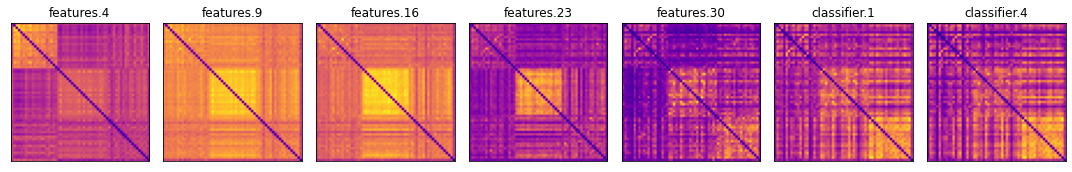

In [173]:

#this cell create a 5 by 5 subplot figure of the RDM based on the network representation layers (note that if more than 25 exists, this code should be modified)
# TODO : this code needs to be modified to fit any shape of data 

rel = list(selected_dictionary.values())


fig,axes=plt.subplots(ncols=len(rel),figsize=(15,6))
min=df_all_levels_rdm.min()
max=df_all_levels_rdm.max()
for i,level in enumerate(rel):
    cols = i
    

    
    cur_df=df_all_levels_rdm.loc[df_all_levels_rdm['rep_level']==level].copy()
    cur_df.drop(columns='rep_level',inplace=True)
    im=axes[cols].imshow(cur_df.values, cmap='plasma')
    axes[cols].set_title(list(informative_nodes_original.keys())[i])
    axes[cols].set_xticks([])
    axes[cols].set_yticks([])

fig.tight_layout()
fig.patch.set_facecolor('white')


rdm_figure_name = IMAGES_FOLDER_NAME + '_RDM_result_plot_last.png'
plt.savefig(rdm_figure_name)

In [20]:
if False: #this section is built to run the contrast types and layers in a loop with different options: 

    num_random_iterations=100
    #extract subset of similar layer based on the averaged similarities: 
    to_plot=False
    all_selected_per_layer_per_contrast_type=[]
    all_mean_sim_vals_per_contrast_type=[]
    for contrast in [True]:#,False]:
        all_selected_per_layer=[]
        all_mean_sim_vals=[]
        #move this here (was in the lower loop and we only need it once per contrast type)
        return_dict=extract_similarity_contrast_by_layers(subset_selection_df,layers=layers_for_extraction,normalize=True,diagonal_value=np.nan,create_contrast=contrast)
        contrast_similarity_per_layer=return_dict['contrast_similarity_per_layer']
        mapping_dict=return_dict['mapping_dict']
        contrast_per_layer=return_dict['contrast_per_layer']
        all_layers_matrices=return_dict['all_layers_matrices']
        for i in range(num_random_iterations):
            starttime=time.time()
            #layers_for_extraction=['low_features_normed','medium_features_normed','high_features_normed'] #defines which layers to extract image similairty 
            layers_for_extraction=new_level_names
            
            #select the best images: 
            selected_per_layer=select_similar_subset(contrast_similarity_per_layer=contrast_similarity_per_layer,subset_size=subset_size,seed_type = 'best',random_selection_order=True)
            reveresed_mapping_dict={value:images_info.loc[images_info['img_name']==key.replace('.pkl','.jpg')]['full_path_to_img'].values[0] for key,value in mapping_dict.items()}
            

            mean_sim_values=calculate_mean_paired_similarity(selected_per_layer,contrast_similarity_per_layer)

            all_mean_sim_vals.append(mean_sim_values)
            all_selected_per_layer.append(selected_per_layer)
            endtime=time.time()
            print(f'trial duration: {i}',endtime-starttime)
        #save the contrast condition in higher order list:     
        all_selected_per_layer_per_contrast_type.append(all_selected_per_layer)
        all_mean_sim_vals_per_contrast_type.append(all_mean_sim_vals)


    file_name = IMAGES_FOLDER_NAME +'.pkl'
    with open(file_name,'wb') as handle:
        pickle.dump(all_selected_per_layer_per_contrast_type,handle)
        pickle.dump(all_mean_sim_vals_per_contrast_type,handle)


    # saving the selected images to subfolder 
    # outputs folder name 
    output_folder_name = IMAGES_FOLDER_NAME + '_' + 'selected_final_images'
    # create the outputs folder 
    outputs_folder_location = os.path.join(os.path.dirname(FULL_PATH_PARENT_FOLDER),(IMAGES_FOLDER_NAME + '_' + 'selected_final_images'))
    if os.path.isdir(outputs_folder_location):
        pass 
    else: 
        os.makedirs(outputs_folder_location)

    for l,selected_images in enumerate(selected_per_layer): 
        # subfolder name 
        subfolder_name = f'layer_{l}'
        # subfolder location 
        subfolder_location = os.path.join(outputs_folder_location,subfolder_name)
        # create new subfolder 

        if not os.path.isdir(subfolder_location):
            os.makedirs(subfolder_location)

        # all of the images paths 
        selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
        # all images names 
        selected_images_names=[os.path.basename(selected_images_path) for selected_images_path in selected_images_paths]

        for i, image in enumerate(selected_images_paths):

            img = Image.open(image)
            name = selected_images_names[i]
            full_path = os.path.join(subfolder_location,name)

            img.save(full_path)



    best_iteration_ind=np.argmax(np.mean(all_mean_sim_vals_per_contrast_type[0],axis=1))
    selected_per_layer=all_selected_per_layer_per_contrast_type[0][best_iteration_ind]


    #convert_back_to_img_identities and plot the images: 
    reveresed_mapping_dict={value:images_info.loc[images_info['img_name']==key.replace('.pkl','.jpg')]['full_path_to_img'].values[0] for key,value in mapping_dict.items()}
    images_names=[]
    for l,selected_images in enumerate(selected_per_layer): 
        selected_images_paths=[reveresed_mapping_dict[k] for k in selected_images]
        selected_images_names=[os.path.basename(selected_images_path).replace('.jpg','.pkl') for selected_images_path in selected_images_paths]
        #plot the image in one column: 
        images_names.append(selected_images_names)
        paths = selected_images_paths    



    relevant_images_names_for_similarity_df=np.array(images_names).flatten()
    new_df=pd.DataFrame()

    for i,(img1,img2) in enumerate(similarity_df[['image1','image2']].values): 
        if (img1 in relevant_images_names_for_similarity_df) and (img2 in relevant_images_names_for_similarity_df):
            new_df=pd.concat([new_df,pd.DataFrame(similarity_df.iloc[i])],ignore_index=True, axis=1)





    create_RDM=True

    if create_RDM:
        df_all_levels_rdm=pd.DataFrame()
        levels=[col for col in new_df.T.columns if 'level' in col]  
        for level in levels: 
            _,layer_df=get_RDM_from_layer(new_df.T.copy(),level)
            ordered_layer_df=pd.DataFrame()
            for i,img in enumerate(relevant_images_names_for_similarity_df):
                ordered_layer_df=pd.concat([ordered_layer_df,layer_df.loc[img,relevant_images_names_for_similarity_df]],axis=1)

            
            ordered_layer_df['rep_level']=level
            df_all_levels_rdm=pd.concat([df_all_levels_rdm,ordered_layer_df],axis=0)
        df_all_levels_rdm.to_csv('all_RDMs.csv',index=False)    
    else:
        df_all_levels_rdm=pd.read_csv('all_RDMs.csv')




    #this cell create a 5 by 5 subplot figure of the RDM based on the network representation layers (note that if more than 25 exists, this code should be modified)
    # TODO : this code needs to be modified to fit any shape of data 

    rel = list(selected_dictionary.values())


    fig,axes=plt.subplots(ncols=len(rel),figsize=(15,6))
    min=df_all_levels_rdm.min()
    max=df_all_levels_rdm.max()
    for i,level in enumerate(rel):
        cols = i
        

        
        cur_df=df_all_levels_rdm.loc[df_all_levels_rdm['rep_level']==level].copy()
        cur_df.drop(columns='rep_level',inplace=True)
        im=axes[cols].imshow(cur_df.values, cmap='plasma')
        axes[cols].set_title(list(informative_nodes_original.keys())[i])
        axes[cols].set_xticks([])
        axes[cols].set_yticks([])

    fig.tight_layout()
    fig.patch.set_facecolor('white')


    rdm_figure_name = IMAGES_FOLDER_NAME + '_RDM_result_plot.png'
    plt.savefig(rdm_figure_name)

trial duration: 0 1547.2913415431976
trial duration: 1 1572.5794925689697
trial duration: 2 1552.8054463863373
trial duration: 3 1563.4479587078094
trial duration: 4 1552.8284282684326
trial duration: 5 1529.577068567276
trial duration: 6 1550.3540859222412
trial duration: 7 1547.2081995010376
trial duration: 8 1541.8979818820953
trial duration: 9 1532.0189452171326
trial duration: 10 1567.3410232067108
trial duration: 11 1570.9574434757233
trial duration: 12 1570.3738985061646
trial duration: 13 1606.80229139328
trial duration: 14 1525.3549048900604
